# MWE Shared on Discourse: 
# Solve 2D Poisson Using Ruge-Stueben and Smoothed-Aggregation AMG from AlgebraicMultigrid.jl  

<b> Goal: </b> compare performance of AMG methods implemented in AlgebraicMultigrid.jl as preconditioner for the CG-method with direct solution methods implemented in backslash. Comparison is performed in sequential (i.e. no parallel computation).    

<b> Findings: </b>: using AMG results in 
- important reduction of memory usage;
- grid independent convergence; 
- limited reduction of CPU time;
- these findings confirm similar finding by master student 

<b> Questions: </b> 
- is what follows executed too naively? Can faster coarsening be implemented? 
- is what follows confirmed elsewhere? 
- do more performant implementations exists (in PETSc.jl for instance)? 
- how can implementation ofc AMG be improved?  

## Import Packages  

In [39]:
using Kronecker 

using LinearAlgebra 
using SparseArrays 

using IterativeSolvers
using Preconditioners
using AlgebraicMultigrid

using BenchmarkTools
using Profile
using ProfileView

using Plots

## Section 1: Build Linear System Matrix and Right-Hand Side Vector 

In [8]:
function buildMat1D(N)
  Nm1 = N-1; Np1 = N+1 
  h = 1/N; h2 = h*h; 
  stencil = [-1/h2, 2/h2, -1/h2]; 
  #..Allocate row, column and value vector 
  I = zeros(Int64,3*Nm1) # allocate 1D array of Int64 
  J = zeros(Int64,3*Nm1) # allocate 1D array of Int64 
  vals = zeros(3*Nm1)
  #..Construct row, column and value vector 
  for i in 2:N
    offset = 3*(i-2)
    I[[offset+1, offset+2, offset+3]] = [i,i,i]
    J[[offset+1, offset+2, offset+3]] = [i-1,i,i+1]
    vals[[offset+1, offset+2, offset+3]] = stencil
  end 
  #..Build matrix for interior rows   
  A = sparse(I,J,vals,Np1,Np1)
  #..Build matrix for boundary rows
  A[1,1] = 1; A[end,end]=1; A[2,1] =0; A[end-1,end]=0; 
  return A 
end 

function buildMat2D(N)
    A1d = buildMat1D(N)
    A2d = KroneckerSum(A1d, A1d) # using lazy evaluation 
    return A2d 
end

function buildVec2D(N)
    Np1 = N+1
    n = Np1^2
    b2d = ones(n)
    return b2d  
end

buildVec2D (generic function with 1 method)

In [44]:
N =100
A2d = buildMat2D(N)
b = buildVec2D(N)
A = sparse(collect(A2d))
println(size(b))
println(size(A))

(10201,)
(10201, 10201)


## Section 2: Solving Linear System using Backslask (as reference) 

In [45]:
@benchmark A\b

BenchmarkTools.Trial: 523 samples with 1 evaluation.
 Range (min … max):  6.753 ms … 109.288 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.486 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.556 ms ±   8.541 ms  ┊ GC (mean ± σ):  0.39% ± 1.55%

  █▅▄▃▃▂                                                       
  ██████▇▇▆▄▅▆▄▅▅▄▄▁▁▁▄▁▁▄▁▁▄▅▅▁▄▄▄▁▄▁▄▁▄▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▄▁▁▄ ▇
  6.75 ms      Histogram: log(frequency) by time      46.8 ms <

 Memory estimate: 7.86 MiB, allocs estimate: 66.

## Section 3: Linear System Solve using Ruge-Stueben AMG as Preconditioner for CG 

In [46]:
p = AMGPreconditioner{RugeStuben}(A);
println(p)

AMGPreconditioner{RugeStuben, AlgebraicMultigrid.MultiLevel{AlgebraicMultigrid.Pinv{Float64}, GaussSeidel{SymmetricSweep}, GaussSeidel{SymmetricSweep}, SparseMatrixCSC{Float64, Int64}, Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}, SparseMatrixCSC{Float64, Int64}, AlgebraicMultigrid.MultiLevelWorkspace{Vector{Float64}, 1}}, AlgebraicMultigrid.V}(Multilevel Solver
-----------------
Operator Complexity: 2.184
Grid Complexity: 1.677
No. of Levels: 7
Coarse Solver: Pinv
Level     Unknowns     NonZeros
-----     --------     --------
    1        10201        49793 [45.79%]
    2         5097        43897 [40.37%]
    3         1326        11220 [10.32%]
    4          348         2834 [ 2.61%]
    5           99          783 [ 0.72%]
    6           30          180 [ 0.17%]
    7           10           36 [ 0.03%]
, AlgebraicMultigrid.V())


In [47]:
@benchmark cg(A, b, Pl=p, log=false)

BenchmarkTools.Trial: 580 samples with 1 evaluation.
 Range (min … max):  8.504 ms …  10.069 ms  ┊ GC (min … max): 0.00% … 14.30%
 Time  (median):     8.601 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.622 ms ± 102.507 μs  ┊ GC (mean ± σ):  0.03% ±  0.59%

       █▄█▅▇▄▂▅▄▃                                              
  ▂▂▄▆████████████▇▅▄▅▄▅▄▃▃▃▃▃▃▃▃▂▂▁▂▂▁▃▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂ ▃
  8.5 ms          Histogram: frequency by time        9.05 ms <

 Memory estimate: 319.95 KiB, allocs estimate: 18.

  1	1.69e+01
  2	2.34e+00
  3	2.77e-01
  4	1.54e-02
  5	4.29e-04
  6	3.17e-05
  7	3.39e-06
  8	1.02e-07



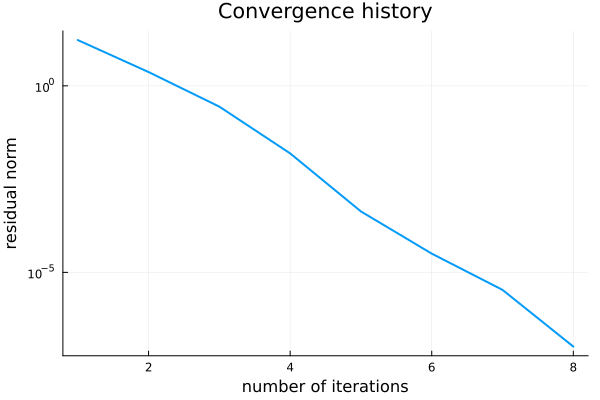

In [48]:
x, ch =cg(A, b, Pl=p, log=true, verbose=true);

p1=plot(ch[:resnorm], yaxis=:log,lw=2,legend=false)
xlabel!("number of iterations") 
ylabel!("residual norm")
title!("Convergence history")

plot(p1) 

## Section 4: Linear System Solve using Smoothed Aggregation AMG as Preconditioner for CG 

In [49]:
p = AMGPreconditioner{SmoothedAggregation}(A);
println(p)

AMGPreconditioner{SmoothedAggregation, AlgebraicMultigrid.MultiLevel{AlgebraicMultigrid.Pinv{Float64}, GaussSeidel{SymmetricSweep}, GaussSeidel{SymmetricSweep}, SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}, AlgebraicMultigrid.MultiLevelWorkspace{Vector{Float64}, 1}}, AlgebraicMultigrid.V}(Multilevel Solver
-----------------
Operator Complexity: 1.348
Grid Complexity: 1.206
No. of Levels: 6
Coarse Solver: Pinv
Level     Unknowns     NonZeros
-----     --------     --------
    1        10201        49793 [74.19%]
    2         1806        15184 [22.62%]
    3          236         1860 [ 2.77%]
    4           40          248 [ 0.37%]
    5           11           25 [ 0.04%]
    6            5            5 [ 0.01%]
, AlgebraicMultigrid.V())


In [50]:
@benchmark cg(A, b, Pl=p, log=true)

BenchmarkTools.Trial: 658 samples with 1 evaluation.
 Range (min … max):  7.490 ms …   9.148 ms  ┊ GC (min … max): 0.00% … 16.71%
 Time  (median):     7.560 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.597 ms ± 131.428 μs  ┊ GC (mean ± σ):  0.06% ±  0.88%

   ▃▅█▃▁▃                                                      
  ▆██████▇▇▇█▇▇▇▆▃▅▄▄▄▃▄▃▂▁▁▃▃▂▂▂▂▂▂▁▂▂▃▂▁▂▂▂▂▂▁▁▁▁▂▂▂▁▂▁▁▁▁▂ ▃
  7.49 ms         Histogram: frequency by time        8.09 ms <

 Memory estimate: 400.31 KiB, allocs estimate: 53.